<font size="5">Second UltraTrail Run</font>

In this notebook the performance of an Akida model is evaluated on a data set according to the UltraTrail
experimental setup. The noise in the test set is fixed to a certain SNR.

In [1]:
# Import modules and dependencies

import os
from os import listdir
from os.path import isdir, join
import pathlib

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models


import akida
from akida import FullyConnected
from akida import evaluate_sparsity
import cnn2snn
from cnn2snn import check_model_compatibility
from cnn2snn import quantize
from cnn2snn import quantize_layer
from cnn2snn import convert

from keras import Model
from keras.layers import (Input, Reshape, Activation, Flatten, Rescaling, Add, Dropout)

import akida_models
from akida_models import layer_blocks
from akida_models.layer_blocks import conv_block, separable_conv_block, dense_block


from math import ceil



In [2]:
# If needed, set seed for experiment reproducibility

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

<font size="5"> 1. Load the Data Set</font>

In [3]:
# Define directory

data_dir = pathlib.Path('data/Modded_Google')

In [4]:
# Check commands

targets = np.array(tf.io.gfile.listdir(str(data_dir)))
targets = targets[targets != 'README.md']

print('Known and unknown commands:', targets)

Known and unknown commands: ['off' 'up' 'down' 'on' 'stop' 'yes' 'right' 'unknown' 'left' 'go' 'no'
 'silence']


In [5]:
# Loading preprocessed Data

feature_sets_path = '/home/sebastian/Schreibtisch/Masterarbeit/Audio/'
feature_sets_filename = 'final_SNR_audio.npz'

CNN_model_filename = 'final_CNN_ultratrail_SNR_model.h5'
Quantized_model_filename = 'final_quantized_ultratrail_SNR_model.h5'
Akida_model_filename = 'final_akida_ultratrail_SNR_model.h5'

In [6]:
# Load feature sets

feature_sets = np.load(join(feature_sets_path, feature_sets_filename))

print('Feature Sets: ', feature_sets.files)


Feature Sets:  ['x_train', 'y_train', 'x_val', 'y_val', 'x_test1', 'y_test1', 'x_test10', 'y_test10', 'x_test20', 'y_test20', 'x_test100', 'y_test100', 'x_test1000', 'y_test1000']


In [7]:
# Assign feature sets

x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']

x_test1 = feature_sets['x_test1']
y_test1 = feature_sets['y_test1']
x_test10 = feature_sets['x_test10']
y_test10 = feature_sets['y_test10']
x_test20 = feature_sets['x_test20']
y_test20 = feature_sets['y_test20']
x_test100 = feature_sets['x_test100']
y_test100 = feature_sets['y_test100']
x_test1000 = feature_sets['x_test1000']
y_test1000 = feature_sets['y_test1000']


In [8]:
# Look at tensor dimensions

print('x_train shape: ', x_train.shape)
print('x_val shape: ', x_val.shape)
print('x_test shape: ', x_test1.shape)

x_train shape:  (34976, 40, 101)
x_val shape:  (4371, 40, 101)
x_test shape:  (4371, 40, 101)


Check the dimensions of the data set. 
Is the unknown and silence category roughly 10% (Category 7 and 11)?

In [10]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0.0: 2697,
 1.0: 2606,
 2.0: 2889,
 3.0: 2747,
 4.0: 2874,
 5.0: 2966,
 6.0: 2747,
 7.0: 3513,
 8.0: 2770,
 9.0: 2786,
 10.0: 2849,
 11.0: 3532}

In [11]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0.0: 358,
 1.0: 340,
 2.0: 343,
 3.0: 373,
 4.0: 335,
 5.0: 358,
 6.0: 363,
 7.0: 439,
 8.0: 381,
 9.0: 335,
 10.0: 333,
 11.0: 413}

In [12]:
unique, counts = np.unique(y_test1, return_counts=True)
dict(zip(unique, counts))

{0.0: 372,
 1.0: 323,
 2.0: 348,
 3.0: 351,
 4.0: 354,
 5.0: 368,
 6.0: 338,
 7.0: 419,
 8.0: 351,
 9.0: 357,
 10.0: 363,
 11.0: 427}

In [13]:
# Define the number of labels

num_labels = len(unique)
print('number of labels: ', num_labels)
#print(x_train.shape)

number of labels:  12


In [14]:
# CNN for conversion expects (batch, height, width, channels)
# The channels can either be 1 for gray-scaled images or 3 for RGB-images

x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)

x_test1 = x_test1.reshape(x_test1.shape[0], 
                        x_test1.shape[1], 
                        x_test1.shape[2], 
                        1)

x_test10 = x_test10.reshape(x_test10.shape[0], 
                        x_test10.shape[1], 
                        x_test10.shape[2], 
                        1)

x_test20 = x_test20.reshape(x_test20.shape[0], 
                        x_test20.shape[1], 
                        x_test20.shape[2], 
                        1)

x_test100 = x_test100.reshape(x_test100.shape[0], 
                        x_test100.shape[1], 
                        x_test100.shape[2], 
                        1)

x_test1000 = x_test1000.reshape(x_test1000.shape[0], 
                        x_test1000.shape[1], 
                        x_test1000.shape[2], 
                        1)


print('Add dimension to all data: Order Train, Val, Test')
print(x_train.shape)
print(x_val.shape)
print(x_test1.shape)
print(x_test10.shape)
print(x_test20.shape)
print(x_test100.shape)
print(x_test1000.shape)


Add dimension to all data: Order Train, Val, Test
(34976, 40, 101, 1)
(4371, 40, 101, 1)
(4371, 40, 101, 1)
(4371, 40, 101, 1)
(4371, 40, 101, 1)
(4371, 40, 101, 1)
(4371, 40, 101, 1)


<font size="5">2. Train and Save the CNN-Model</font>

In [15]:
# Define the input shape for the CNN, namely the dimension of 1 MFCC

input_shape = x_test1.shape[1:]
print('Input shape of 1 Tensor/MFCC: ', input_shape)

Input shape of 1 Tensor/MFCC:  (40, 101, 1)


In [16]:
# CNN created with the functional API and from akida_models layer_blocks

inputs = Input(shape=input_shape)
x = Rescaling(1. / 255)(inputs)
x = conv_block(x,
               filters=32,
               kernel_size=(3, 3),
               padding='same',
               strides=(2, 2),
               use_bias=False,
               name='conv_0',
               add_batchnorm=True)

x = separable_conv_block(x,
                         filters=32,
                         kernel_size=(3, 3),
                         padding='same',
                         use_bias=False,
                         name='separable_1',
                         add_batchnorm=True)
x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=64,
                         kernel_size=(3, 3),
                         padding='same',
                         strides=(2,2),
                         use_bias=False,
                         name='separable_2',
                         add_batchnorm=True)

x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=128,
                         kernel_size=(3, 3),
                         padding='same',
                         use_bias=False,
                         name='separable_3',
                         add_batchnorm=True)

x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=128,
                         kernel_size=(3, 3),
                         padding='same',
                         strides=(2,2),
                         use_bias=False,
                         name='separable_4',
                         add_batchnorm=True)

x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=256,
                         kernel_size=(3, 3),
                         padding='same',
                         use_bias=False,
                         name='separable_5',
                         add_batchnorm=True)

x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=256,
                         kernel_size=(3, 3),
                         padding='same',
                         strides=(2,2),
                         use_bias=False,
                         name='separable_6',
                         add_batchnorm=True)

x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=512,
                         kernel_size=(3, 3),
                         padding='same',
                         strides=(2,2),
                         use_bias=False,
                         name='separable_7',
                         add_batchnorm=True)

x = Dropout(0.25)(x)

x = separable_conv_block(x,
                         filters=1024,
                         kernel_size=(3, 3),
                         padding='same',
                         use_bias=False,
                         name='separable_8',
                         pooling='global_avg',
                         add_batchnorm=True)

x = Dropout(0.25)(x)


shape = (1, 1, int(1024))
x = Reshape(shape, name='reshape_1')(x)

x = Flatten()(x)
x = layers.Dense(units = 12, activation='linear', use_bias = True)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

outputs = layers.Activation('softmax')(x)

CNN_model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_model')

CNN_model.summary()


2022-04-17 21:34:30.803581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 21:34:30.837321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 21:34:30.837489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 21:34:30.838049: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 101, 1)]      0         
_________________________________________________________________
rescaling (Rescaling)        (None, 40, 101, 1)        0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 20, 51, 32)        288       
_________________________________________________________________
conv_0_BN (BatchNormalizatio (None, 20, 51, 32)        128       
_________________________________________________________________
conv_0_relu (ReLU)           (None, 20, 51, 32)        0         
_________________________________________________________________
separable_1 (SeparableConv2D (None, 20, 51, 32)        1312      
_________________________________________________________________
separable_1_BN (BatchNormali (None, 20, 51, 32)        12

In [17]:
# Check if model is compatible

print("Model compatible for Akida conversion:", check_model_compatibility(CNN_model))

Model compatible for Akida conversion: True


In [18]:
# Compile the CNN model

CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [19]:
# Train model for 500 epochs and keep the best model measured on the validation accuracy. 

EPOCHS = 500
checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = CNN_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[model_checkpoint_callback],
)

CNN_model.load_weights(checkpoint_filepath)

2022-04-17 21:34:38.648478: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-04-17 21:34:41.261574: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8301
2022-04-17 21:34:43.858974: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-17 21:34:44.400677: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1093/1093 [==============================] - 17s 10ms/step - loss: 2.2575 - accuracy: 0.2091 - val_loss: 2.1397 - val_accuracy: 0.3175
Epoch 2/500
1093/1093 [==============================] - 11s 10ms/step - loss: 1.4000 - accuracy: 0.5518 - val_loss: 0.8911 - val_accuracy: 0.7138
Epoch 3/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.9847 - accuracy: 0.6896 - val_loss: 0.7276 - val_accuracy: 0.7728
Epoch 4/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.8087 - accuracy: 0.7471 - val_loss: 0.5561 - val_accuracy: 0.8250
Epoch 5/500
1093/1093 [==============================] - 11s 10ms/step - loss: 0.7142 - accuracy: 0.7762 - val_loss: 0.5430 - val_accuracy: 0.8254
Epoch 6/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.6523 - accuracy: 0.7981 - val_loss: 0.7136 - val_accuracy: 0.7881
Epoch 7/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.6029 - accuracy: 0.8139 - val_loss: 0.4527 - val_acc

Epoch 57/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.2138 - accuracy: 0.9296 - val_loss: 0.2077 - val_accuracy: 0.9366
Epoch 58/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.2079 - accuracy: 0.9326 - val_loss: 0.2151 - val_accuracy: 0.9325
Epoch 59/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.2114 - accuracy: 0.9298 - val_loss: 0.2330 - val_accuracy: 0.9314
Epoch 60/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.2022 - accuracy: 0.9328 - val_loss: 0.2059 - val_accuracy: 0.9380
Epoch 61/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.2000 - accuracy: 0.9352 - val_loss: 0.2021 - val_accuracy: 0.9398
Epoch 62/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.2025 - accuracy: 0.9327 - val_loss: 0.1952 - val_accuracy: 0.9401
Epoch 63/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.2001 - accuracy: 0.9339 - val_loss: 0

1093/1093 [==============================] - 10s 9ms/step - loss: 0.1134 - accuracy: 0.9610 - val_loss: 0.2177 - val_accuracy: 0.9414
Epoch 168/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.1171 - accuracy: 0.9603 - val_loss: 0.2097 - val_accuracy: 0.9417
Epoch 169/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.1114 - accuracy: 0.9621 - val_loss: 0.2189 - val_accuracy: 0.9385
Epoch 170/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.1127 - accuracy: 0.9617 - val_loss: 0.2179 - val_accuracy: 0.9419
Epoch 171/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.1133 - accuracy: 0.9622 - val_loss: 0.2212 - val_accuracy: 0.9389
Epoch 172/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.1129 - accuracy: 0.9625 - val_loss: 0.2302 - val_accuracy: 0.9357
Epoch 173/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.1137 - accuracy: 0.9610 - val_loss: 0.2256 -

1093/1093 [==============================] - 10s 9ms/step - loss: 0.0853 - accuracy: 0.9712 - val_loss: 0.2179 - val_accuracy: 0.9410
Epoch 278/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.0877 - accuracy: 0.9704 - val_loss: 0.2190 - val_accuracy: 0.9426
Epoch 279/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.0875 - accuracy: 0.9691 - val_loss: 0.2277 - val_accuracy: 0.9428
Epoch 280/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.0820 - accuracy: 0.9716 - val_loss: 0.2169 - val_accuracy: 0.9421
Epoch 281/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.0858 - accuracy: 0.9691 - val_loss: 0.2231 - val_accuracy: 0.9435
Epoch 282/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.0843 - accuracy: 0.9710 - val_loss: 0.2265 - val_accuracy: 0.9410
Epoch 283/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.0828 - accuracy: 0.9724 - val_loss: 0.2296 -

1093/1093 [==============================] - 10s 10ms/step - loss: 0.0686 - accuracy: 0.9767 - val_loss: 0.2341 - val_accuracy: 0.9428
Epoch 388/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.0705 - accuracy: 0.9761 - val_loss: 0.2306 - val_accuracy: 0.9437
Epoch 389/500
1093/1093 [==============================] - 10s 10ms/step - loss: 0.0679 - accuracy: 0.9769 - val_loss: 0.2384 - val_accuracy: 0.9444
Epoch 390/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.0721 - accuracy: 0.9769 - val_loss: 0.2388 - val_accuracy: 0.9414
Epoch 391/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.0667 - accuracy: 0.9772 - val_loss: 0.2390 - val_accuracy: 0.9423
Epoch 392/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.0682 - accuracy: 0.9768 - val_loss: 0.2503 - val_accuracy: 0.9410
Epoch 393/500
1093/1093 [==============================] - 10s 10ms/step - loss: 0.0661 - accuracy: 0.9773 - val_loss: 0.234

1093/1093 [==============================] - 10s 10ms/step - loss: 0.0593 - accuracy: 0.9798 - val_loss: 0.2586 - val_accuracy: 0.9396
Epoch 498/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.0596 - accuracy: 0.9798 - val_loss: 0.2512 - val_accuracy: 0.9412
Epoch 499/500
1093/1093 [==============================] - 10s 9ms/step - loss: 0.0558 - accuracy: 0.9801 - val_loss: 0.2714 - val_accuracy: 0.9433
Epoch 500/500
1093/1093 [==============================] - 10s 10ms/step - loss: 0.0591 - accuracy: 0.9801 - val_loss: 0.2563 - val_accuracy: 0.9437


/tmp/ipykernel_106266/897927363.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
/tmp/ipykernel_106266/897927363.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
/tmp/ipykernel_106266/897927363.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
/tmp/ipykernel_106266/897927363.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will ta

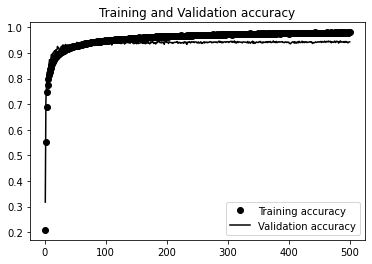

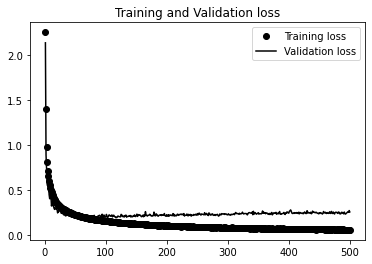

In [20]:
# Plot results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
plt.plot(epochs, val_loss, 'b', label='Validation loss',color='k')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [21]:
# Save CNN-Model

models.save_model(CNN_model, CNN_model_filename)


In [22]:
# Print performance of the CNN model 

score = CNN_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')

score = CNN_model.evaluate(x_test1, y_test1, verbose=0)
print('Accuracy on test set with SNR of 1 of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_test10, y_test10, verbose=0)
print('Accuracy on test set with SNR of 10 of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_test20, y_test20, verbose=0)
print('Accuracy on test set with SNR of 20 of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_test100, y_test100, verbose=0)
print('Accuracy on test set with SNR of 100 of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_test1000, y_test1000, verbose=0)
print('Accuracy on test set with SNR of 1000 of CNN:', score[1] * 100,'%')

Accuracy on train set of CNN: 99.9685525894165 %
Accuracy on validation set of CNN: 94.71516609191895 %
Accuracy on test set with SNR of 1 of CNN: 79.56989407539368 %
Accuracy on test set with SNR of 10 of CNN: 91.16907119750977 %
Accuracy on test set with SNR of 20 of CNN: 94.23472881317139 %
Accuracy on test set with SNR of 100 of CNN: 94.53214406967163 %
Accuracy on test set with SNR of 1000 of CNN: 94.66941356658936 %


<font size="5">3. Quantize the CNN-Model</font>

In [23]:
# Quantize the CNN-model

quantized_model = quantize(CNN_model,
                           input_weight_quantization=8,
                           weight_quantization=4,
                           activ_quantization=4)
quantized_model.summary()

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 101, 1)]      0         
_________________________________________________________________
rescaling (Rescaling)        (None, 40, 101, 1)        0         
_________________________________________________________________
conv_0 (QuantizedConv2D)     (None, 20, 51, 32)        320       
_________________________________________________________________
conv_0_relu (ActivationDiscr (None, 20, 51, 32)        0         
_________________________________________________________________
separable_1 (QuantizedSepara (None, 20, 51, 32)        1344      
_________________________________________________________________
separable_1_relu (Activation (None, 20, 51, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 51, 32)        0 

In [24]:
# Check model accuracy after quantization

quantized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [25]:
score = quantized_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of quantized CNN:', score[1] * 100,'%')

score = quantized_model.evaluate(x_test1, y_test1, verbose=0)
print('Accuracy on test set with SNR of 1 of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_test10, y_test10, verbose=0)
print('Accuracy on test set with SNR of 10 of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_test20, y_test20, verbose=0)
print('Accuracy on test set with SNR of 20 of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_test100, y_test100, verbose=0)
print('Accuracy on test set with SNR of 100 of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_test1000, y_test1000, verbose=0)
print('Accuracy on test set with SNR of 1000 of quantized CNN:', score[1] * 100,'%')

Accuracy on train set of quantized CNN: 64.2068862915039 %
Accuracy on validation set of quantized CNN: 59.43719744682312 %
Accuracy on test set with SNR of 1 of quantized CNN: 51.15534067153931 %
Accuracy on test set with SNR of 10 of quantized CNN: 57.97300338745117 %
Accuracy on test set with SNR of 20 of quantized CNN: 58.430564403533936 %
Accuracy on test set with SNR of 100 of quantized CNN: 58.1102728843689 %
Accuracy on test set with SNR of 1000 of quantized CNN: 57.5383186340332 %


In [26]:
# Quantization aware training, in which the best model is saved

EPOCHS = 500
checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = quantized_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    batch_size = 32,
    callbacks=[model_checkpoint_callback],
)

quantized_model.load_weights(checkpoint_filepath)

Epoch 1/500
1093/1093 [==============================] - 17s 13ms/step - loss: 0.3752 - accuracy: 0.8769 - val_loss: 0.2514 - val_accuracy: 0.9369
Epoch 2/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.1712 - accuracy: 0.9545 - val_loss: 0.2341 - val_accuracy: 0.9419
Epoch 3/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.1466 - accuracy: 0.9623 - val_loss: 0.2301 - val_accuracy: 0.9426
Epoch 4/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.1349 - accuracy: 0.9656 - val_loss: 0.2264 - val_accuracy: 0.9426
Epoch 5/500
1093/1093 [==============================] - 15s 13ms/step - loss: 0.1295 - accuracy: 0.9667 - val_loss: 0.2273 - val_accuracy: 0.9433
Epoch 6/500
1093/1093 [==============================] - 15s 13ms/step - loss: 0.1225 - accuracy: 0.9688 - val_loss: 0.2302 - val_accuracy: 0.9421
Epoch 7/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.1222 - accuracy: 0.9687 - val_loss: 0

1093/1093 [==============================] - 14s 13ms/step - loss: 0.0847 - accuracy: 0.9808 - val_loss: 0.2308 - val_accuracy: 0.9439
Epoch 112/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0863 - accuracy: 0.9802 - val_loss: 0.2293 - val_accuracy: 0.9433
Epoch 113/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0837 - accuracy: 0.9809 - val_loss: 0.2308 - val_accuracy: 0.9421
Epoch 114/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0870 - accuracy: 0.9796 - val_loss: 0.2287 - val_accuracy: 0.9437
Epoch 115/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0848 - accuracy: 0.9809 - val_loss: 0.2320 - val_accuracy: 0.9449
Epoch 116/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0835 - accuracy: 0.9810 - val_loss: 0.2322 - val_accuracy: 0.9428
Epoch 117/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0843 - accuracy: 0.9807 - val_loss: 0

1093/1093 [==============================] - 14s 13ms/step - loss: 0.0809 - accuracy: 0.9813 - val_loss: 0.2333 - val_accuracy: 0.9444
Epoch 167/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0813 - accuracy: 0.9817 - val_loss: 0.2211 - val_accuracy: 0.9460
Epoch 168/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0823 - accuracy: 0.9810 - val_loss: 0.2226 - val_accuracy: 0.9453
Epoch 169/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0826 - accuracy: 0.9810 - val_loss: 0.2344 - val_accuracy: 0.9401
Epoch 170/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0792 - accuracy: 0.9819 - val_loss: 0.2310 - val_accuracy: 0.9430
Epoch 171/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0809 - accuracy: 0.9817 - val_loss: 0.2380 - val_accuracy: 0.9417
Epoch 172/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0797 - accuracy: 0.9814 - val_loss: 0

1093/1093 [==============================] - 14s 13ms/step - loss: 0.0778 - accuracy: 0.9828 - val_loss: 0.2281 - val_accuracy: 0.9449
Epoch 222/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0759 - accuracy: 0.9836 - val_loss: 0.2327 - val_accuracy: 0.9423
Epoch 223/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0778 - accuracy: 0.9827 - val_loss: 0.2356 - val_accuracy: 0.9403
Epoch 224/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0736 - accuracy: 0.9843 - val_loss: 0.2284 - val_accuracy: 0.9437
Epoch 225/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0775 - accuracy: 0.9834 - val_loss: 0.2311 - val_accuracy: 0.9417
Epoch 226/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0765 - accuracy: 0.9833 - val_loss: 0.2287 - val_accuracy: 0.9437
Epoch 227/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0765 - accuracy: 0.9833 - val_loss: 0

1093/1093 [==============================] - 14s 13ms/step - loss: 0.0699 - accuracy: 0.9860 - val_loss: 0.2273 - val_accuracy: 0.9456
Epoch 277/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0697 - accuracy: 0.9855 - val_loss: 0.2332 - val_accuracy: 0.9446
Epoch 278/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0699 - accuracy: 0.9857 - val_loss: 0.2299 - val_accuracy: 0.9430
Epoch 279/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0713 - accuracy: 0.9851 - val_loss: 0.2289 - val_accuracy: 0.9469
Epoch 280/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0712 - accuracy: 0.9851 - val_loss: 0.2395 - val_accuracy: 0.9433
Epoch 281/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0705 - accuracy: 0.9862 - val_loss: 0.2332 - val_accuracy: 0.9398
Epoch 282/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0694 - accuracy: 0.9857 - val_loss: 0

1093/1093 [==============================] - 14s 13ms/step - loss: 0.0821 - accuracy: 0.9813 - val_loss: 0.2338 - val_accuracy: 0.9430
Epoch 332/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0798 - accuracy: 0.9829 - val_loss: 0.2306 - val_accuracy: 0.9439
Epoch 333/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0805 - accuracy: 0.9820 - val_loss: 0.2310 - val_accuracy: 0.9433
Epoch 334/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0786 - accuracy: 0.9826 - val_loss: 0.2318 - val_accuracy: 0.9419
Epoch 335/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0817 - accuracy: 0.9820 - val_loss: 0.2329 - val_accuracy: 0.9430
Epoch 336/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0803 - accuracy: 0.9819 - val_loss: 0.2354 - val_accuracy: 0.9439
Epoch 337/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0824 - accuracy: 0.9812 - val_loss: 0

1093/1093 [==============================] - 14s 13ms/step - loss: 0.0792 - accuracy: 0.9825 - val_loss: 0.2380 - val_accuracy: 0.9430
Epoch 387/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0783 - accuracy: 0.9816 - val_loss: 0.2362 - val_accuracy: 0.9435
Epoch 388/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0812 - accuracy: 0.9817 - val_loss: 0.2345 - val_accuracy: 0.9444
Epoch 389/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0759 - accuracy: 0.9836 - val_loss: 0.2309 - val_accuracy: 0.9449
Epoch 390/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0783 - accuracy: 0.9831 - val_loss: 0.2428 - val_accuracy: 0.9428
Epoch 391/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0790 - accuracy: 0.9817 - val_loss: 0.2354 - val_accuracy: 0.9412
Epoch 392/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0807 - accuracy: 0.9814 - val_loss: 0

1093/1093 [==============================] - 14s 13ms/step - loss: 0.0787 - accuracy: 0.9824 - val_loss: 0.2358 - val_accuracy: 0.9423
Epoch 442/500
1093/1093 [==============================] - 14s 12ms/step - loss: 0.0761 - accuracy: 0.9832 - val_loss: 0.2328 - val_accuracy: 0.9410
Epoch 443/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0750 - accuracy: 0.9842 - val_loss: 0.2319 - val_accuracy: 0.9435
Epoch 444/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0745 - accuracy: 0.9839 - val_loss: 0.2311 - val_accuracy: 0.9442
Epoch 445/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0764 - accuracy: 0.9833 - val_loss: 0.2287 - val_accuracy: 0.9442
Epoch 446/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0777 - accuracy: 0.9822 - val_loss: 0.2307 - val_accuracy: 0.9433
Epoch 447/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0774 - accuracy: 0.9829 - val_loss: 0

1093/1093 [==============================] - 14s 13ms/step - loss: 0.0745 - accuracy: 0.9838 - val_loss: 0.2326 - val_accuracy: 0.9423
Epoch 497/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0758 - accuracy: 0.9836 - val_loss: 0.2295 - val_accuracy: 0.9451
Epoch 498/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0767 - accuracy: 0.9830 - val_loss: 0.2294 - val_accuracy: 0.9426
Epoch 499/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0767 - accuracy: 0.9831 - val_loss: 0.2317 - val_accuracy: 0.9437
Epoch 500/500
1093/1093 [==============================] - 14s 13ms/step - loss: 0.0760 - accuracy: 0.9834 - val_loss: 0.2318 - val_accuracy: 0.9430


/tmp/ipykernel_106266/897927363.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
/tmp/ipykernel_106266/897927363.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
/tmp/ipykernel_106266/897927363.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
/tmp/ipykernel_106266/897927363.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will ta

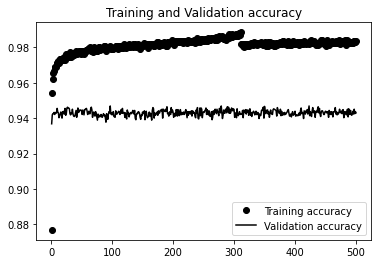

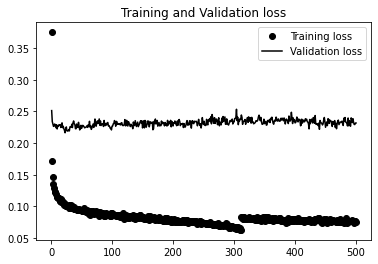

In [27]:
# Plot results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
plt.plot(epochs, val_loss, 'b', label='Validation loss',color='k')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [28]:
# Save quantized CNN model

models.save_model(quantized_model, Quantized_model_filename)

In [19]:
##### Optional if pretrained ##########

quantized_model.load_weights(Quantized_model_filename)
quantized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [29]:
# Print peformance of the quantized CNN after quantization aware training

score = quantized_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of quantized CNN:', score[1] * 100,'%')

score = quantized_model.evaluate(x_test1, y_test1, verbose=0)
print('Accuracy on test set with SNR of 1 of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_test10, y_test10, verbose=0)
print('Accuracy on test set with SNR of 10 of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_test20, y_test20, verbose=0)
print('Accuracy on test set with SNR of 20 of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_test100, y_test100, verbose=0)
print('Accuracy on test set with SNR of 100 of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_test1000, y_test1000, verbose=0)
print('Accuracy on test set with SNR of 1000 of quantized CNN:', score[1] * 100,'%')

Accuracy on train set of quantized CNN: 99.97426867485046 %
Accuracy on validation set of quantized CNN: 94.69228982925415 %
Accuracy on test set with SNR of 1 of quantized CNN: 77.76252627372742 %
Accuracy on test set with SNR of 10 of quantized CNN: 91.19194746017456 %
Accuracy on test set with SNR of 20 of quantized CNN: 93.80004405975342 %
Accuracy on test set with SNR of 100 of quantized CNN: 94.44063305854797 %
Accuracy on test set with SNR of 1000 of quantized CNN: 94.50926780700684 %


<font size="5">4. Akida Model Conversion</font>

In [30]:
#  Convert to an Akida model

akida_model = convert(quantized_model)
akida_model.summary()

                 Model Summary                 
_______________________________________________
Input shape   Output shape  Sequences  Layers
[40, 101, 1]  [1, 1, 12]    1          10    
_______________________________________________

                SW/conv_0-dense (Software)                 
___________________________________________________________
Layer (type)             Output shape   Kernel shape     
conv_0 (InputConv.)      [51, 20, 32]   (3, 3, 1, 32)    
___________________________________________________________
separable_1 (Sep.Conv.)  [51, 20, 32]   (3, 3, 32, 1)    
___________________________________________________________
                                        (1, 1, 32, 32)   
___________________________________________________________
separable_2 (Sep.Conv.)  [26, 10, 64]   (3, 3, 32, 1)    
___________________________________________________________
                                        (1, 1, 32, 64)   
_______________________________________________________

In [31]:
# Print performance of the final Akida model

results = akida_model.predict(x_train)
accuracy = (y_train == results).mean()

print('SNN accuracy on training set after conversion:', accuracy * 100,'%')

results = akida_model.predict(x_val)
accuracy = (y_val == results).mean()

print('SNN accuracy on validation set after conversion:', accuracy * 100,'%')

results = akida_model.predict(x_test1)
accuracy = (y_test1 == results).mean()
print('SNN accuracy on test set with SNR of 1 after conversion:', accuracy * 100,'%')

results = akida_model.predict(x_test10)
accuracy = (y_test10 == results).mean()
print('SNN accuracy on test set with SNR of 10 after conversion:', accuracy * 100,'%')

results = akida_model.predict(x_test20)
accuracy = (y_test20 == results).mean()
print('SNN accuracy on test set with SNR of 20 after conversion:', accuracy * 100,'%')

results = akida_model.predict(x_test100)
accuracy = (y_test100 == results).mean()
print('SNN accuracy on test set with SNR of 100 after conversion:', accuracy * 100,'%')

results = akida_model.predict(x_test1000)
accuracy = (y_test1000 == results).mean()
print('SNN accuracy on test set with SNR of 1000 after conversion:', accuracy * 100,'%')

SNN accuracy on training set after conversion: 99.9742680695334 %
SNN accuracy on validation set after conversion: 94.71516815374056 %
SNN accuracy on test set with SNR of 1 after conversion: 77.3278425989476 %
SNN accuracy on test set with SNR of 10 after conversion: 91.12331274307938 %
SNN accuracy on test set with SNR of 20 after conversion: 93.98307023564402 %
SNN accuracy on test set with SNR of 100 after conversion: 94.55502173415694 %
SNN accuracy on test set with SNR of 1000 after conversion: 94.69229009380004 %
